# Figure 2a

## Plot the results of omega for a couple of samples

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../../')
from consensus_variables import *

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
plots_dir = "plot/fig2a_needles_all_samples"

### Generate needle plot

In [5]:
def plot_count_track(count_df, 
                        gene_len,
                        axes, 
                        colors_dict,
                        ax=0, 
                        negative=False, 
                        label_pos_track=None,
                        label_neg_track=None,
                        ymargin=None,
                        alpha=1,
                        indel=False,
                        n_batches = 10
                    ):

    # Shuffle the data and split into batches
    shuffled_df = count_df.sample(frac=1, random_state=42).reset_index(drop=True)
    batches = np.array_split(shuffled_df, n_batches)

    legend_list = []
    pos_df = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    
    for batch_idx, batch in enumerate(batches):
        for cnsq in [#'indel',
                     'nonsense', 'missense', 'synonymous',
                     # 'splicing'
                    ]:
            
            if indel == False and cnsq == "indel":
                continue
        
            count_cnsq_df = batch[batch["Consequence"] == cnsq].reset_index(drop=True)
            count_cnsq_df = pos_df.merge(count_cnsq_df, on="Pos", how="left")
    
            axes[ax].vlines(count_cnsq_df["Pos"], ymin=0, ymax=count_cnsq_df["Count"], lw=1, zorder=1, alpha=0.5, color=colors_dict["hv_lines_needle"])
            axes[ax].scatter(count_cnsq_df["Pos"], count_cnsq_df["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part

            if cnsq not in legend_list:
                axes[ax].scatter(count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                                 alpha=alpha, lw=0.1, ec="black", s=60, label= "Truncating" if cnsq == 'nonsense' else cnsq.capitalize(), color=colors_dict[cnsq]) 
                legend_list.append(cnsq)
            else:
                axes[ax].scatter(count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                                 alpha=alpha, lw=0.1, ec="black", s=60, color=colors_dict[cnsq]) 


In [6]:
somatic_maf = pd.read_table(somatic_maf_file)
somatic_maf_clean = somatic_maf[(somatic_maf["canonical_SYMBOL"].isin(panel_all_genes)) 
                                & (somatic_maf["TYPE"] == 'SNV')
                                & (~somatic_maf["FILTER.not_in_exons"])
                                & (somatic_maf['canonical_Protein_position'] != '-')
                                ].reset_index(drop = True)
somatic_maf_clean['canonical_Protein_position'] = somatic_maf_clean['canonical_Protein_position'].astype(int)

/tmp/ipykernel_4073277/3549228594.py:1: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  somatic_maf = pd.read_table(somatic_maf_file)


In [7]:
counts_per_position = somatic_maf_clean.groupby(by = ["SAMPLE_ID", "canonical_SYMBOL", 'canonical_Consequence_broader', 'canonical_Protein_position'])['ALT_DEPTH'].size().to_frame('Count').reset_index()
counts_per_position.columns = ["SAMPLE_ID", 'Gene', 'Consequence', 'Pos', 'Count']
counts_per_position.head()

,SAMPLE_ID,Gene,Consequence,Pos,Count
0,P19_0001_BDO_01,ARID1A,missense,509,1
1,P19_0001_BDO_01,ARID1A,missense,797,1
2,P19_0001_BDO_01,ARID1A,missense,1440,1
3,P19_0001_BDO_01,ARID1A,missense,1976,1
4,P19_0001_BDO_01,ARID1A,missense,2063,1


In [8]:
# metrics_colors_dictionary = {"ofml"        : "viridis_r",
#                              "ofml_score"  : "#6A33E0",
#                              "omega_trunc" : "#FA5E32",
#                              "omega_synon" : "#89E4A2",
#                              "omega_miss"  : "#FABE4A",
#                              "o3d_score"   : "#6DBDCC",
#                              "o3d_cluster" : "skyblue",
#                              "o3d_prob"    : "darkgray",
#                              "frameshift"  : "#E4ACF4",
#                              "inframe"     : "C5",
#                              "hv_lines"    : "lightgray", # horizontal and vertical lines,
#                              "hv_lines_needle" : "gray",
#                              "needle_obs"  : "#003366",
#                              "omega_miss_tert" : "#f5840c",
#                              "omega_synon_tert": "#378c12",
#                              "nonsense" : "#FA5E32",
#                              "synonymous" : "#89E4A2",
#                              "missense"  : "#FABE4A",

#                              "indel"       : "#ECC4F7", 
#                              "splicing"    : "#A1C5DF",
#                             }

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


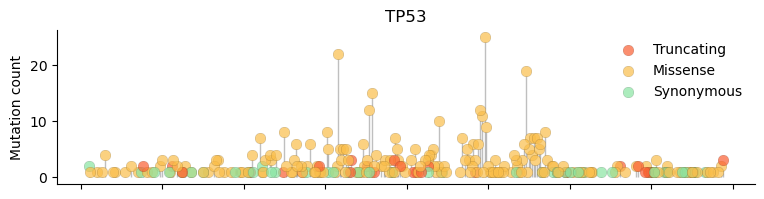

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


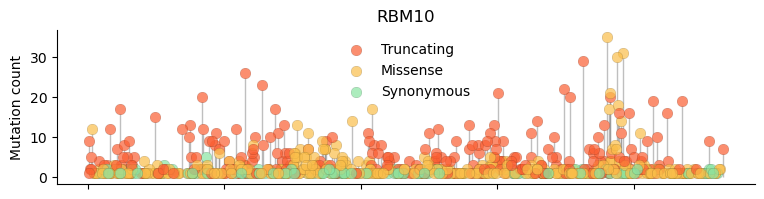

In [10]:
for donor, samplesss in [('All samples', all_sample_names_dirty)]:
    #for gene in counts_per_position["Gene"].unique():
    for gene in ["TP53", "RBM10"]:
        mut_count_df = counts_per_position[(counts_per_position["Gene"] == gene)
                                            & (counts_per_position["SAMPLE_ID"].isin(samplesss))]
        mut_count_df = mut_count_df.groupby(by = ["Pos", "Consequence"])["Count"].sum().reset_index()
        
        fig, ax = plt.subplots(1,1, figsize = (9,2))
        plot_count_track(mut_count_df, gene_len=mut_count_df["Pos"].max(), axes=[ax], ax=0,
                            colors_dict=metrics_colors_dictionary, indel=False, alpha = 0.7)
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_ylabel("Mutation count")
        ax.set_xlabel("")
        ax.set_title(f"{gene}")
        ax.set_xticklabels([])
        
        plt.legend(frameon = False)

        plt.savefig(f"{plots_dir}/{gene}.all_samples_needle.randomized.png", bbox_inches='tight', dpi = 300)
        plt.show()
        plt.close()

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


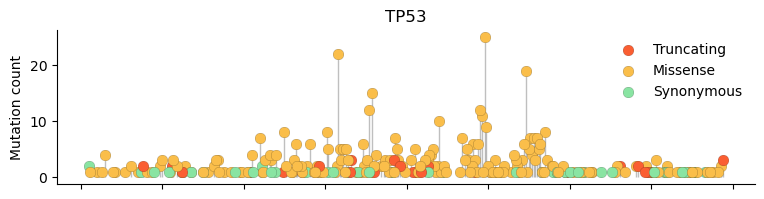

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


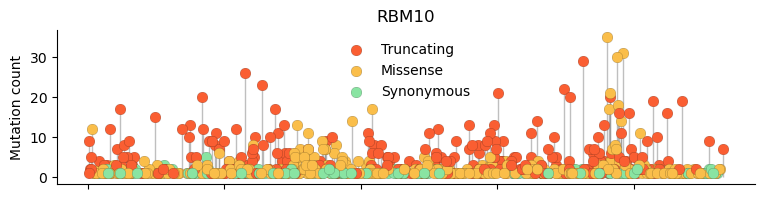

In [11]:
for donor, samplesss in [('All samples', all_sample_names_dirty)]:
    for gene in ["TP53", "RBM10"]:
        mut_count_df = counts_per_position[(counts_per_position["Gene"] == gene)
                                            & (counts_per_position["SAMPLE_ID"].isin(samplesss))]
        mut_count_df = mut_count_df.groupby(by = ["Pos", "Consequence"])["Count"].sum().reset_index()
        
        fig, ax = plt.subplots(1,1, figsize = (9,2))
        plot_count_track(mut_count_df, gene_len=mut_count_df["Pos"].max(), axes=[ax], ax=0,
                            colors_dict=metrics_colors_dictionary, indel=False, alpha = 1)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_ylabel("Mutation count")
        ax.set_xlabel("")

        ax.set_title(f"{gene}")

        ax.set_xticklabels([])
        plt.legend(frameon = False)

        plt.savefig(f"{plots_dir}/{gene}.all_samples_needle.png", bbox_inches='tight', dpi = 300)
        plt.show()
        plt.close()

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


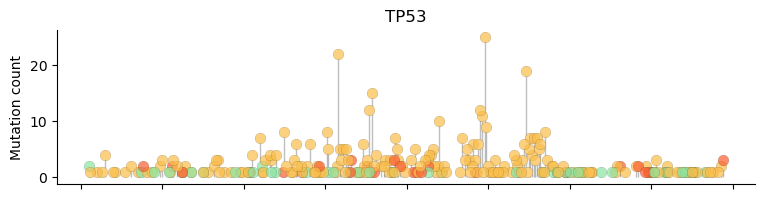

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


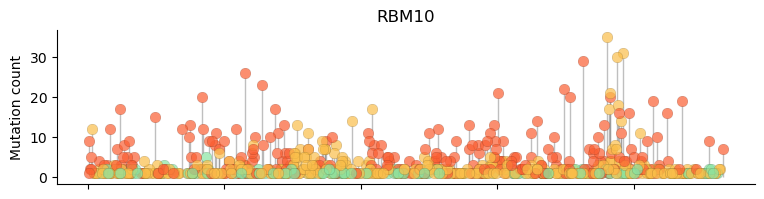

In [12]:
for donor, samplesss in [('All samples', all_sample_names_dirty)]:
    for gene in ["TP53", "RBM10"]:
        mut_count_df = counts_per_position[(counts_per_position["Gene"] == gene)
                                            & (counts_per_position["SAMPLE_ID"].isin(samplesss))]
        mut_count_df = mut_count_df.groupby(by = ["Pos", "Consequence"])["Count"].sum().reset_index()

        fig, ax = plt.subplots(1,1, figsize = (9,2))
        plot_count_track(mut_count_df, gene_len=mut_count_df["Pos"].max(), axes=[ax], ax=0,
                            colors_dict=metrics_colors_dictionary, indel=False, alpha = 0.7)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # ax.set_ylim(0,2.6)
        ax.set_ylabel("Mutation count")
        ax.set_xlabel("")

        ax.set_title(f"{gene}")

        ax.set_xticklabels([])

        plt.savefig(f"{plots_dir}/{gene}.all_samples_needle.nolegend.png", bbox_inches='tight', dpi = 300)
        plt.show()
        plt.close()